### Main Project 1 script

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [2]:
########################################################################################################################
## Custom Transformers for Grid Search

from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')


class Importer(BaseEstimator, TransformerMixin):

    def __init__(self, remove=None):
        self.remove = remove

    def transform(self, raw_documents, *_):
        if self.remove is not None:
            if 'headers' in self.remove:
                raw_documents = [self.strip_newsgroup_header(text) for text in raw_documents]
            if 'footers' in self.remove:
                raw_documents = [self.strip_newsgroup_footer(text) for text in raw_documents]

        return raw_documents

    def fit(self, *_):
        return self

    ## Taken from twenty_newsgroups.py
    @staticmethod
    def strip_newsgroup_header(text):
        """
        Given text in "news" format, strip the headers, by removing everything
        before the first blank line.

        Parameters
        ----------
        text : string
            The text from which to remove the signature block.
        """
        _before, _blankline, after = text.partition('\n\n')
        return after

    _QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                           r'|^In article|^Quoted from|^\||^>)')

    ## Taken from twenty_newsgroups.py
    @staticmethod
    def strip_newsgroup_footer(text):
        """
        Given text in "news" format, attempt to remove a signature block.

        As a rough heuristic, we assume that signatures are set apart by either
        a blank line or a line made of hyphens, and that it is the last such line
        in the file (disregarding blank lines at the end).

        Parameters
        ----------
        text : string
            The text from which to remove the signature block.
        """
        lines = text.strip().split('\n')
        for line_num in range(len(lines) - 1, -1, -1):
            line = lines[line_num]
            if line.strip().strip('-') == '':
                break

        if line_num > 0:
            return '\n'.join(lines[:line_num])
        else:
            return text

In [3]:
########################################################################################################################
# Lemmatization functions used by CountVectorizer

# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def isfloat(string):
    try:
        float(string)
        return True
    except:
        return False

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not isfloat(word))

In [4]:
# categories = ['comp.graphics', 'comp.os.ms-windows.misc',
#               'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
#               'rec.autos', 'rec.motorcycles',
#               'rec.sport.baseball', 'rec.sport.hockey']
# train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
# test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

#### Question 1

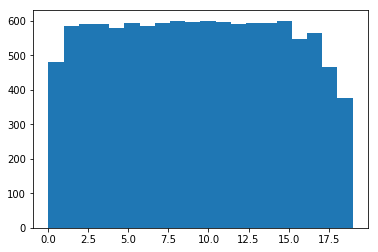

In [5]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
plt.hist(newsgroups_train.target, 20)
plt.show()

#### Question 2

In [6]:
########################################################################################################################
# Fetching 20NewsGroups dataset

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Change labels into binary based on two well separated classes: Computer (labels 0-3) and Recreational (labels 4-7).
twenty_train_binary_labels = np.zeros(len(twenty_train.target))
for k in range(len(twenty_train.target)):
    if twenty_train.target[k] >= 4:
        twenty_train_binary_labels[k] = 1
twenty_test_binary_labels = np.zeros(len(twenty_test.target))
for k in range(len(twenty_test.target)):
    if twenty_test.target[k] >= 4:
        twenty_test_binary_labels[k] = 1
class_names = ['Computer Technology', 'Recreational Activity']

In [7]:
########################################################################################################################
# Push lemmatized documents through CountVectorizer

count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')

# do for training
X_lemmatized_train_counts = count_vect.fit_transform(twenty_train.data)

# do for testing
X_lemmatized_test_counts = count_vect.transform(twenty_test.data)

In [8]:
########################################################################################################################
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_lemmatized_train_tfidf = tfidf_transformer.fit_transform(X_lemmatized_train_counts)
print(X_lemmatized_train_tfidf.shape)

# do for testing
X_lemmatized_test_tfidf = tfidf_transformer.transform(X_lemmatized_test_counts)
print(X_lemmatized_test_tfidf.shape)

(4732, 16593)
(3150, 16593)


#### Question 3

In [9]:
# Perform LSI using the truncated SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
Y_lsi_train_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
Y_lsi_test_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

(4732, 50)
(50, 16593)
(4732, 50)
(50, 16593)


In [10]:
# Perform NMF

from sklearn.decomposition import NMF

model = NMF(n_components=50, init='random', random_state=42)
W_nmf_train_reduced = model.fit_transform(X_lemmatized_train_tfidf)
H_nmf_train_reduced = model.components_

print(W_nmf_train_reduced.shape)
print(H_nmf_train_reduced.shape)

W_nmf_test_reduced = model.transform(X_lemmatized_test_tfidf)
H_nmf_test_reduced = model.components_

(4732, 50)
(50, 16593)


In [11]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(W_nmf_train_reduced, H_nmf_train_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(X_lsi_train_reduced, Y_lsi_train_reduced), 'fro')**2

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  3938.937503841036
LSI:  3895.3842712019564


In [12]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_test_tfidf - np.matmul(W_nmf_test_reduced, H_nmf_test_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_test_tfidf - np.matmul(X_lsi_test_reduced, Y_lsi_test_reduced), 'fro')**2

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  2687.499548403796
LSI:  2676.461431710984


##### Aside: Define function to nicely plot the confusion matrix

In [13]:
# Taken from scikit-learn website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Question 4

In [28]:
# Training 2 linear SVMs

from sklearn.svm import LinearSVC

# hard margin
gamma_1 = 1000
clf_svc_1 = LinearSVC(C=gamma_1,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_1 = clf_svc_1.predict(X_lsi_test_reduced)

# using max_iter=100000 because otherwise the hard margin classifier does not converge

#soft margin
gamma_2 = 0.0001
clf_svc_2 = LinearSVC(C=gamma_2,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_2 = clf_svc_2.predict(X_lsi_test_reduced)

Confusion matrix, without normalization
[[1503   57]
 [  31 1559]]


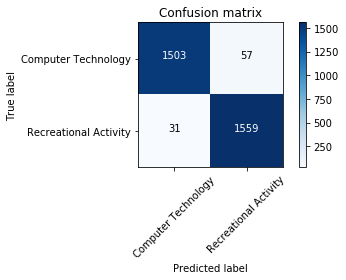

Normalized confusion matrix
[[0.96346154 0.03653846]
 [0.01949686 0.98050314]]


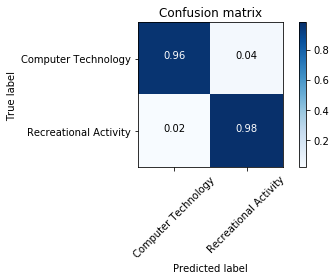

Accuracy for linear SVM hard margin:  0.9720634920634921
Precision score for linear SVM hard margin:  0.9647277227722773
Recall score for linear SVM hard margin:  0.980503144654088
F-1 score for linear SVM hard margin: 0.9725514660012476


In [29]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the hard margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for linear SVM hard margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_1), classes=class_names)
plt.savefig('svm-hard-conf.eps', format='eps', dpi=1000)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_1), classes=class_names, normalize=True)
plt.show()


# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM hard margin: ', accuracy_score(twenty_test_binary_labels, predicted_svc_1))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM hard margin: ', precision_score(twenty_test_binary_labels, predicted_svc_1))
print('Recall score for linear SVM hard margin: ', recall_score(twenty_test_binary_labels, predicted_svc_1))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM hard margin:', f1_score(twenty_test_binary_labels, predicted_svc_1))

Confusion matrix, without normalization
[[ 341 1219]
 [   0 1590]]


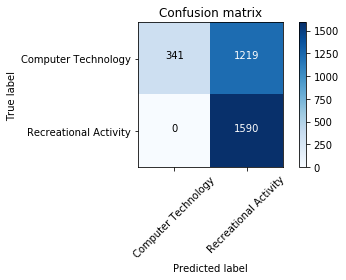

Normalized confusion matrix
[[0.21858974 0.78141026]
 [0.         1.        ]]


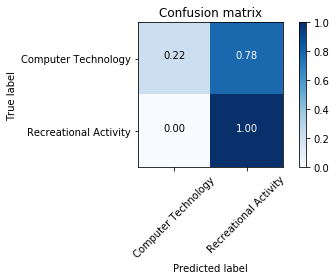

Accuracy for linear SVM soft margin:  0.613015873015873
Precision score for linear SVM soft margin:  0.5660377358490566
Recall score for linear SVM soft margin:  1.0
F-1 score for linear SVM soft margin: 0.7228915662650602


In [30]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the soft margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for linear SVM soft margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_2))

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_2), classes=class_names)
plt.savefig('svm-soft-conf.eps', format='eps', dpi=1000)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_2), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM soft margin: ', accuracy_score(twenty_test_binary_labels, predicted_svc_2))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM soft margin: ', precision_score(twenty_test_binary_labels, predicted_svc_2))
print('Recall score for linear SVM soft margin: ', recall_score(twenty_test_binary_labels, predicted_svc_2))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM soft margin:', f1_score(twenty_test_binary_labels, predicted_svc_2))

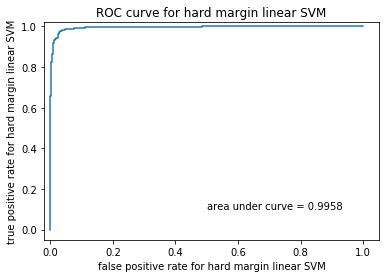

In [31]:
# ROC curve for hard margin SVM

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_1 = clf_svc_1.decision_function(X_lsi_test_reduced)
fpr_svc_1, tpr_svc_1, thresholds_svc_1 = roc_curve(twenty_test_binary_labels, score_svc_1)

plt.figure()
plt.plot(fpr_svc_1, tpr_svc_1)
plt.title('ROC curve for hard margin linear SVM')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_svc_1))
plt.xlabel('false positive rate for hard margin linear SVM')
plt.ylabel('true positive rate for hard margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.savefig('svm-hard-roc.eps', format='eps', dpi=1000)
plt.show()

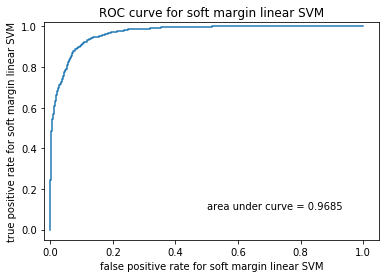

In [32]:
# ROC curve for soft margin SVM

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_2 = clf_svc_2.decision_function(X_lsi_test_reduced)
fpr_svc_2, tpr_svc_2, thresholds_svc_2 = roc_curve(twenty_test_binary_labels, score_svc_2)

plt.figure()
plt.plot(fpr_svc_2, tpr_svc_2)
plt.title('ROC curve for soft margin linear SVM')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_svc_2))
plt.xlabel('false positive rate for soft margin linear SVM')
plt.ylabel('true positive rate for soft margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.savefig('svm-soft-roc.eps', format='eps', dpi=1000)
plt.show()

 **Hard Margin SVM is better because accuracy for hard margin is 97% whereas it is 66% for soft margin**

In [ ]:
# Cross validation to choose best gamma for the Linear SVM
import statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

# Set the parameters to be determined by cross-validation
tuned_parameters = {'C': [0.001, 0.01, 0.1 , 1, 10, 100, 1000]}

# We are using the F1 score to determine the best value of gamma (C) for the linear SVM classifier

clf_svc_cv = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=5, scoring= 'f1_macro')
clf_svc_cv.fit(X_lsi_train_reduced, twenty_train_binary_labels)

print("Best value of C: ")
print()
print(clf_svc_cv.best_params_)
print()
print("Grid scores: ")
print()
means = clf_svc_cv.cv_results_['mean_test_score']
stds = clf_svc_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_svc_cv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:114

**Plotting the ROC curve and report the confusion matrix and calculate the
accuracy, recall precision and F-1 score of this best SVM**

Confusion matrix, without normalization
[[1503   57]
 [  31 1559]]


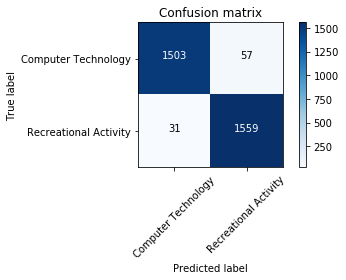

Normalized confusion matrix
[[0.96346154 0.03653846]
 [0.01949686 0.98050314]]


<Figure size 432x288 with 0 Axes>

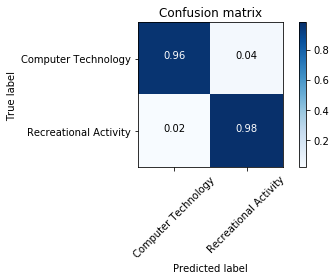

Accuracy for the best linear SVM classifier:  0.9720634920634921
Precision score for the best linear SVM classifier:  0.9647277227722773
Recall score for the best linear SVM classifier:  0.980503144654088
F-1 score for the best linear SVM classifier: 0.9725514660012476


In [20]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the best linear SVM classifier

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for the best linear SVM classifier: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_1), classes=class_names)
plt.savefig('svm-best-conf.eps', format='eps', dpi=1000)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_1), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for the best linear SVM classifier: ', accuracy_score(twenty_test_binary_labels, predicted_svc_1))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for the best linear SVM classifier: ', precision_score(twenty_test_binary_labels, predicted_svc_1))
print('Recall score for the best linear SVM classifier: ', recall_score(twenty_test_binary_labels, predicted_svc_1))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for the best linear SVM classifier:', f1_score(twenty_test_binary_labels, predicted_svc_1))

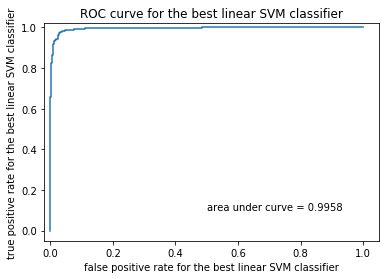

<Figure size 432x288 with 0 Axes>

In [21]:
# ROC curve for the best linear SVM classifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_1 = clf_svc_1.decision_function(X_lsi_test_reduced)
fpr_svc_1, tpr_svc_1, thresholds_svc_1 = roc_curve(twenty_test_binary_labels, score_svc_1)

plt.figure()
plt.plot(fpr_svc_1, tpr_svc_1)
plt.title('ROC curve for the best linear SVM classifier')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_svc_1))
plt.xlabel('false positive rate for the best linear SVM classifier')
plt.ylabel('true positive rate for the best linear SVM classifier')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.savefig('svm-best-roc.eps', format='eps', dpi=1000)
plt.show()

#### Question 5

In [29]:
# Train an unregularized logistic regression classifier.

from sklearn.linear_model import LogisticRegression

# To be unregularized, we make the inverse of the regularization strength C 
# to be large to approximate an unregularized classifier.
clf = LogisticRegression(random_state=42, C=500, max_iter=100, solver='lbfgs').fit(X_lsi_train_reduced, twenty_train_binary_labels)

# score = clf.decision_function(X_lsi_test_reduced)
predicted = clf.predict(X_lsi_test_reduced)

Confusion matrix, without normalization
[[1499   61]
 [  30 1560]]


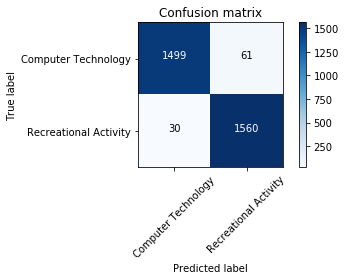

Normalized confusion matrix
[[0.96089744 0.03910256]
 [0.01886792 0.98113208]]


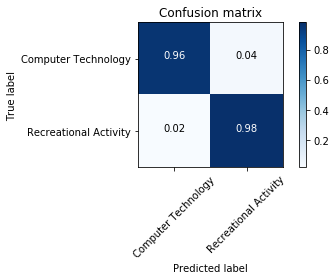

Accuracy:  0.9711111111111111
Precision score:  0.9623689080814312
Recall score:  0.9811320754716981
F-1 score: 0.9716599190283399


In [30]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix: \n', confusion_matrix(twenty_test_binary_labels, predicted))
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names)
plt.show()
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(twenty_test_binary_labels, predicted))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score: ', precision_score(twenty_test_binary_labels, predicted))
print('Recall score: ', recall_score(twenty_test_binary_labels, predicted))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score:', f1_score(twenty_test_binary_labels, predicted))

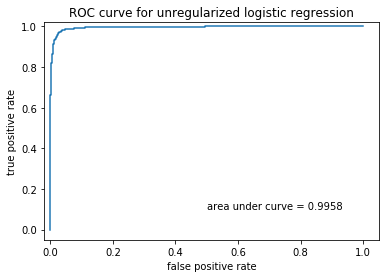

In [31]:
# ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score = clf.decision_function(X_lsi_test_reduced)
fpr, tpr, thresholds = roc_curve(twenty_test_binary_labels, score)

plt.figure()
plt.plot(fpr, tpr)
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score))
plt.title('ROC curve for unregularized logistic regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

Optimal regularization strength for L1 Regulation:  [0.1]
Accuracy with L1 Regulation for L1 Regulation:  0.9707936507936508
Average precision-recall score for L1 Regulation: 0.9526115713987328
Precision score for L1 Regulation:  0.9606396063960639
Recall score for L1 Regulation:  0.9823899371069182
F-1 score for L1 Regulation: 0.9713930348258706


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


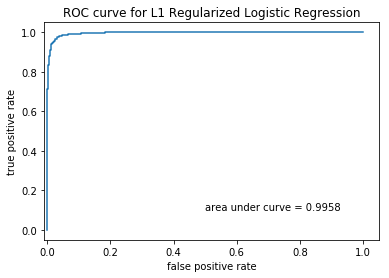


Optimal regularization strength for L2 regulation:  [0.01]
Accuracy with L2 Regulation:  0.9701587301587301
Average precision-recall score for L2 Regulation: 0.9517210668063554
Precision score for L2 Regulation:  0.9600246002460024
Recall score for L2 Regulation:  0.9817610062893082
F-1 score for L2 Regulation: 0.9707711442786069


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


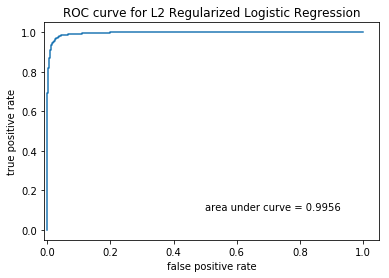

In [32]:
from sklearn.linear_model import LogisticRegressionCV

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

# Define regularization strength values here
REG_STRENGTH_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Determine regulation strength for L1 regulation
clf_L1 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l1', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
l1_reg_strength = 1/clf_L1.C_ # Regulization strength is inverse of optimal Cs
predicted_L1 = clf_L1.predict(X_test)

# Display L1 Stats
print('Optimal regularization strength for L1 Regulation: ', l1_reg_strength)
print('Accuracy with L1 Regulation for L1 Regulation: ', clf_L1.score(X_test, y_test))
print('Average precision-recall score for L1 Regulation:', average_precision_score(y_test, predicted_L1))
print('Precision score for L1 Regulation: ', precision_score(y_test, predicted_L1))
print('Recall score for L1 Regulation: ', recall_score(y_test, predicted_L1))
print('F-1 score for L1 Regulation:', f1_score(y_test, predicted_L1))

# L1 ROC Curve
score_L1 = clf_L1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L1)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L1 Regularized Logistic Regression')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_L1))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

# Determine regulation strength for L2 regulation
clf_L2 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l2', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
L2_reg_strength = 1/clf_L2.C_ # Regulization strength is inverse of optimal Cs
predicted_L2 = clf_L2.predict(X_test)

# Display L2 Stats
print('\nOptimal regularization strength for L2 regulation: ', L2_reg_strength)
print('Accuracy with L2 Regulation: ', clf_L2.score(X_test, y_test))
print('Average precision-recall score for L2 Regulation:', average_precision_score(y_test, predicted_L2))
print('Precision score for L2 Regulation: ', precision_score(y_test, predicted_L2))
print('Recall score for L2 Regulation: ', recall_score(y_test, predicted_L2))
print('F-1 score for L2 Regulation:', f1_score(y_test, predicted_L2))

# L2 ROC Curve
score_L2 = clf_L2.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L2)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L2 Regularized Logistic Regression')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_L2))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

#### Question 6

In [33]:
########################################################################################################################
# Train a Naive Bayes Gaussian classifier on the reduced TFIDF training set from problem 3

from sklearn.naive_bayes import GaussianNB

Confusion matrix, without normalization
[[1294  266]
 [  44 1546]]


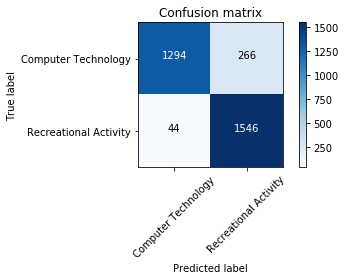

Normalized confusion matrix
[[0.82948718 0.17051282]
 [0.02767296 0.97232704]]


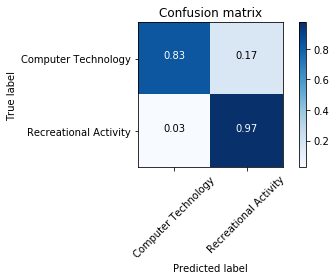

Accuracy for Gaussian NB from LSI:  0.9015873015873016
Average precision-recall score for Gaussian NB from LSI: 0.8435585464974444
Precision score for Gaussian NB from LSI:  0.8532008830022075
Recall score for Gaussian NB from LSI:  0.9723270440251572
F-1 score for Gaussian NB from LSI: 0.9088771310993533


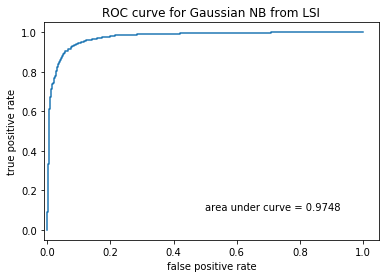

In [34]:
########################################################################################################################
# Generate stats for GaussianNB using LSI for reduction

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

predicted = clf.predict(X_test)

# Confusion Matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names)
plt.show()
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names, normalize=True)
plt.show()

# Display GNB Stats
print('Accuracy for Gaussian NB from LSI: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from LSI')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, prob_score[:, 1]))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

In [27]:
########################################################################################################################
# Generate stats for GaussianNB using NMF for reduction

# # Define training and testing data sets
# X_train = W_nmf_train_reduced
# y_train = twenty_train_binary_labels

# X_test = W_nmf_test_reduced
# y_test = twenty_test_binary_labels

# clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

# predicted = clf.predict(X_test)

# plt.figure()
# plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names)
# plt.show()
# plt.figure()
# plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names, normalize=True)
# plt.show()

# # Display GNB Stats
# print('Accuracy for Gaussian NB for NMF: ', clf.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB for NMF:', average_precision_score(y_test, predicted))
# print('Precision score for Gaussian NB for NMF: ', precision_score(y_test, predicted))
# print('Recall score for Gaussian NB for NMF: ', recall_score(y_test, predicted))
# print('F-1 score for Gaussian NB for NMF:', f1_score(y_test, predicted))

# # GNB ROC Curve
# prob_score = clf.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

# plt.figure()
# plt.plot(fpr, tpr)
# plt.title('ROC curve for Gaussian NB from NMF')
# plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, prob_score[:, 1]))
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.xlim(left=-0.01)
# plt.show()

#### Question 7

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=None)),
    ('vect', CountVectorizer(min_df=1, stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', GaussianNB()),
],
memory=memory
)

param_grid = [
    {
        'import__remove': [None, ['headers', 'footers']],
        'vect__min_df': [3, 5],
        'vect__analyzer': ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(random_state=42, n_components=50), NMF(random_state=42, n_components=50)],
        'clf': [LinearSVC(C=gamma_1,max_iter=100000),
               LogisticRegression(random_state=42, C=0.1, penalty='l1', solver='liblinear'),
               LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear'),
               GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(twenty_train.data, twenty_train_binary_labels)
rmtree(cachedir)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpc9pt30im'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpc9pt30im'" instead.
  app.launch_new_instance()


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=None), [ 'From: rschmitt@shearson.com (Robert Schmitt)\n'
  'Subject: Re: Please Recommend 3D Graphics Library F\n'
  'Reply-To: rschmitt@shearson.com\n'
  'Organization: Lehman Brothers, Inc.\n'
  'Lines: 9\n'
  '\n'
  'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob\n'
  '------------------------------------------------------------------\n'
  'Robert A. Schmitt | Applied Derivatives Technology | Lehman Brothers\n'
  'rschmitt@shearson.com\n'
  '\n'
  '\n',
  'From: mori@volga.mfd.cs.fujitsu.co.jp (Tsuyoshi Mori)\n'
  'Subject: I want use DeskJet on System7\n'
  'Organization: FUJITSU.Ltd., Kawasaki, Japan.\n'
  'Lines: 15\n'
  'Di..., 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.6s, 0.0min
______

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17574 sparse matrix of type '<class 'numpy.int64'>'
	with 329115 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17574 sparse matrix of type '<class 'numpy.float64'>'
	with 329115 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17232 sparse matrix of type '<class 'numpy.int64'>'
	with 324344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17232 sparse matrix of type '<class 'numpy.float64'>'
	with 324344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17671 sparse matrix of type '<class 'numpy.int64'>'
	with 328511 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17671 sparse matrix of type '<class 'numpy.float64'>'
	with 328511 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x17321 sparse matrix of type '<class 'numpy.int64'>'
	with 327753 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x17321 sparse matrix of type '<class 'numpy.float64'>'
	with 327753 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x17420 sparse matrix of type '<class 'numpy.int64'>'
	with 328453 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x17420 sparse matrix of type '<class 'numpy.float64'>'
	with 328453 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.37s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11007 sparse matrix of type '<class 'numpy.int64'>'
	with 306922 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11007 sparse matrix of type '<class 'numpy.float64'>'
	with 306922 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.34s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x10930 sparse matrix of type '<class 'numpy.int64'>'
	with 303063 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x10930 sparse matrix of type '<class 'numpy.float64'>'
	with 303063 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11017 sparse matrix of type '<class 'numpy.int64'>'
	with 306084 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11017 sparse matrix of type '<class 'numpy.float64'>'
	with 306084 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.40s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11109 sparse matrix of type '<class 'numpy.int64'>'
	with 306687 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x11109 sparse matrix of type '<class 'numpy.float64'>'
	with 306687 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.26s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x11048 sparse matrix of type '<class 'numpy.int64'>'
	with 306977 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x11048 sparse matrix of type '<class 'numpy.float64'>'
	with 306977 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

________________________________________________fit_transform_one - 9.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\82140bd2f442b4c2760965176386c41c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c2184b5877206ad033578eaeb7ca465c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Lemmatizer(enabled=True), [ 'From: rschmitt@shearson.com (Robert Schmitt)\n'
  'Subject: Re: Please Recommend 3D Graphics Library F\n'
  'Reply-To: rschmitt@shearson.com\n'
  'Organization: Lehman Brothers, Inc.\n'
  'Lines: 9\n'
  '\n'
  'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob\n'
  '------------------------------------------------------------------\n'
  'Robert A. Schmitt | Applied Derivatives Technology | Lehman Brothers\n'
  'rschmitt@shearson.com\n'
  '\n'
  '\n',
  'From: mori@volga.mfd.cs.fujitsu.co.jp (Tsuyoshi Mori)\n'
  'Subject: I want use DeskJet on System7\n'
  'Organization: FUJITSU.Ltd., Kawasaki, Japan.\n'
  'Lines: 15\n'
  'Di..., 
array([0., ..., 0.]), None)
______________________________________________fit_transform_one - 236.2s, 3.9min
___

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 4.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x15047 sparse matrix of type '<class 'numpy.int64'>'
	with 298635 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x15047 sparse matrix of type '<class 'numpy.float64'>'
	with 298635 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14645 sparse matrix of type '<class 'numpy.int64'>'
	with 293965 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14645 sparse matrix of type '<class 'numpy.float64'>'
	with 293965 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x15146 sparse matrix of type '<class 'numpy.int64'>'
	with 298182 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x15146 sparse matrix of type '<class 'numpy.float64'>'
	with 298182 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.89s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14736 sparse matrix of type '<class 'numpy.int64'>'
	with 297204 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x14736 sparse matrix of type '<class 'numpy.float64'>'
	with 297204 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.9s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14933 sparse matrix of type '<class 'numpy.int64'>'
	with 298556 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x14933 sparse matrix of type '<class 'numpy.float64'>'
	with 298556 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.93s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9261 sparse matrix of type '<class 'numpy.int64'>'
	with 279144 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9261 sparse matrix of type '<class 'numpy.float64'>'
	with 279144 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9178 sparse matrix of type '<class 'numpy.int64'>'
	with 275519 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9178 sparse matrix of type '<class 'numpy.float64'>'
	with 275519 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9256 sparse matrix of type '<class 'numpy.int64'>'
	with 278345 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9256 sparse matrix of type '<class 'numpy.float64'>'
	with 278345 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.09s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9359 sparse matrix of type '<class 'numpy.int64'>'
	with 278994 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x9359 sparse matrix of type '<class 'numpy.float64'>'
	with 278994 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.7s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x9325 sparse matrix of type '<class 'numpy.int64'>'
	with 279612 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x9325 sparse matrix of type '<class 'numpy.float64'>'
	with 279612 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 5.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\81e4258d5fad4d9e070797f8d4490fbf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\a03810ef5f0bbe218e03fe6f4f9ca6d3
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

________________________________________________fit_transform_one - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Lemmatizer(enabled=False), [ 'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob',
  'I used HP DeskJet with Orange Micros Grappler LS on System6.0.5.\n'
  '\n'
  'But now I update system 6.0.5 to System7 with Kanji-Talk 7.1,\n'
  'then I can not print by my DeskJet.\n'
  '\n'
  'Is the Grappler LS old ?\n'
  'Can I use DeskJet on System7 ?\n'
  '\n'
  'Please tell me how to use DeskJet on System7.\n'
  '\n'
  'Thank you\n',
  'Has anyone used the Number Nine (# 9) Video Graphics adaptor with Windows\n'
  'or Windows NT?  What do you think???',
  'I look at zApp and really liked it. However, I think you should\n'
  'wait for version 2.0 (I think it will b..., 
array([0., ..., 0.]), None)
__

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14648 sparse matrix of type '<class 'numpy.int64'>'
	with 241382 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14648 sparse matrix of type '<class 'numpy.float64'>'
	with 241382 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14377 sparse matrix of type '<class 'numpy.int64'>'
	with 237491 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14377 sparse matrix of type '<class 'numpy.float64'>'
	with 237491 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14870 sparse matrix of type '<class 'numpy.int64'>'
	with 242060 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14870 sparse matrix of type '<class 'numpy.float64'>'
	with 242060 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14540 sparse matrix of type '<class 'numpy.int64'>'
	with 241095 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x14540 sparse matrix of type '<class 'numpy.float64'>'
	with 241095 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14676 sparse matrix of type '<class 'numpy.int64'>'
	with 241604 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x14676 sparse matrix of type '<class 'numpy.float64'>'
	with 241604 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9052 sparse matrix of type '<class 'numpy.int64'>'
	with 222536 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9052 sparse matrix of type '<class 'numpy.float64'>'
	with 222536 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x8964 sparse matrix of type '<class 'numpy.int64'>'
	with 219298 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x8964 sparse matrix of type '<class 'numpy.float64'>'
	with 219298 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.95s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9146 sparse matrix of type '<class 'numpy.int64'>'
	with 222772 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9146 sparse matrix of type '<class 'numpy.float64'>'
	with 222772 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9181 sparse matrix of type '<class 'numpy.int64'>'
	with 222996 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x9181 sparse matrix of type '<class 'numpy.float64'>'
	with 222996 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x9172 sparse matrix of type '<class 'numpy.int64'>'
	with 223059 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x9172 sparse matrix of type '<class 'numpy.float64'>'
	with 223059 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 7.1s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\aa99e391a9ea293fe9e5606c774fb7a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d3814fef73b7587228db3c88c700c36d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Lemmatizer(enabled=True), [ 'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob',
  'I used HP DeskJet with Orange Micros Grappler LS on System6.0.5.\n'
  '\n'
  'But now I update system 6.0.5 to System7 with Kanji-Talk 7.1,\n'
  'then I can not print by my DeskJet.\n'
  '\n'
  'Is the Grappler LS old ?\n'
  'Can I use DeskJet on System7 ?\n'
  '\n'
  'Please tell me how to use DeskJet on System7.\n'
  '\n'
  'Thank you\n',
  'Has anyone used the Number Nine (# 9) Video Graphics adaptor with Windows\n'
  'or Windows NT?  What do you think???',
  'I look at zApp and really liked it. However, I think you should\n'
  'wait for version 2.0 (I think it will b..., 
array([0., ..., 0.]), None)
______________________________________________fit_transform_one - 190.2s, 3.2min
___

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x12274 sparse matrix of type '<class 'numpy.int64'>'
	with 217887 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x12274 sparse matrix of type '<class 'numpy.float64'>'
	with 217887 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.48s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11942 sparse matrix of type '<class 'numpy.int64'>'
	with 214038 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11942 sparse matrix of type '<class 'numpy.float64'>'
	with 214038 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.32s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x12508 sparse matrix of type '<class 'numpy.int64'>'
	with 218614 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x12508 sparse matrix of type '<class 'numpy.float64'>'
	with 218614 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.41s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.2s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x12115 sparse matrix of type '<class 'numpy.int64'>'
	with 217509 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x12115 sparse matrix of type '<class 'numpy.float64'>'
	with 217509 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.45s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.1s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x12365 sparse matrix of type '<class 'numpy.int64'>'
	with 218699 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x12365 sparse matrix of type '<class 'numpy.float64'>'
	with 218699 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7455 sparse matrix of type '<class 'numpy.int64'>'
	with 201709 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7455 sparse matrix of type '<class 'numpy.float64'>'
	with 201709 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7344 sparse matrix of type '<class 'numpy.int64'>'
	with 198621 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7344 sparse matrix of type '<class 'numpy.float64'>'
	with 198621 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7516 sparse matrix of type '<class 'numpy.int64'>'
	with 201795 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7516 sparse matrix of type '<class 'numpy.float64'>'
	with 201795 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.0s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x7546 sparse matrix of type '<class 'numpy.int64'>'
	with 202090 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x7546 sparse matrix of type '<class 'numpy.float64'>'
	with 202090 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x7603 sparse matrix of type '<class 'numpy.int64'>'
	with 202645 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x7603 sparse matrix of type '<class 'numpy.float64'>'
	with 202645 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 6.1s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\24d3b627e4bd84ce4ee9874c66ebc3d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c56b7fa0da68707e43b250f5dab6fc69
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d7b798b72b0b48a61f5c3843cf8fcd47
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\138eb4019d84efe5e6d2d4deaad75163
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2f7e4e3c2661e7ed367db9a3890e279b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\ac9ec2dbbaee2a798c5a1dfb0a5f854f
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\1ba87630837e13ff44fffc5cff860023
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\b7d63142df94e915b61cc4ef73b4b229
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\81e4258d5fad4d9e070797f8d4490fbf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\f3ac6faab2250ebe5e42a8152832ae89
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\081e89df4828325f86ab86308c5c4395
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\a19af3aa5754f165fd04d1757d8c15e9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\f9bffbf24398e1c0728612a6441f2105
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\919dc4756a3a16c3baa95ae26da699da
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d9b1ce852fa2fdc16768986ae70ae25b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\e052a42067aa2f29ac25fd1657602c3f
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\5472bffab268af2aa3c34cb831e99776
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\208aa8d3c85ae0878726e53b90a4c81a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\6ecf80f92b9f65c5fa74bcd8dc5f336d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\8cb8181463b9f42cbaaccf832a3b6c0e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c17e99ebaab4286fc5d8d919782040f1
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\6096b35e689fa4de6d394282bb614a8a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\4fd2c801e8ea4eb4a1972203e15c7b6c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\39bdbe11a60926c09fbfbc8c40fda6b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\4e2084a41d9cace588d8ba19ae2deea7
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2a37951d0fc1ea9feafd0ea38299c703
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\52a59114ea4b6adb1fcb6a9d70b2a69f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\ff22a0a95111e42e8f75b5d18b6699a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\dde5f0cd18310fd93426aadc2c926419
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\7b3cd2194e7452419904464815b427ad
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2edae8c2ebea1d4dbc453ce9f4ea41db
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\46fff232d12dc29659b89829c6b03d47
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\de00f5514c015e93315b1cb2bf4fd09e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\82140bd2f442b4c2760965176386c41c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c2184b5877206ad033578eaeb7ca465c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\95781473cb835f47c345377599a2c923
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c01078d7a583c1fcb0b354d3c2a36f0d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\e6ddc848fc3b51ecc59584e3d07f8f90
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2ec8322ae1cec1ed7392c3c64b178eac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2d6d0af0aa8c507aa026e67269cf251c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\ba884b43bd5c8671be011e68ba807344
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2fec721f15299fbf46ebf2d7e0900da3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\8da503a6c0a2054b98511baf676cd7d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\0b1c0efb200a90e35c90f63dd33f71ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\e4562d44973def99b9c54118234ee4b6
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\52c0741434e1cc5ec791f00536d14e5d
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\08c952c6d9db629bd8b493c117ea8197
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\dce612e234b68d6743396e1e3308f6c2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\39bdbe11a60926c09fbfbc8c40fda6b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\214a911d0396ed1904181c853641e8e4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\8db28108706d38ab3b53f6d17cd226e5
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\ce4ea2f51b495c2e1510153574fb81e2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\304391a69b73e02ecac2a99857346e9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d0f97f28861b26f7a68d5d26ee493299
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\b00348d6389ef6510ad1c0c53508c8c8
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\b682fe9012f21c58d2e6568d8ea8a629
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\cff46fd111ce12ba76888a4a050968cb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\99e781be4153c95dd72b74ca4a070c22
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\24d3b627e4bd84ce4ee9874c66ebc3d0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\57e7beeeaf284e96f47572661fbca3b5
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\6dd3a07bedcaf6c50871befe16cf7734
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\307f7e2325db3073054c5bd3545a1892
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\99fa31caa0065daca3f0bc6ea84fd1cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2ec8322ae1cec1ed7392c3c64b178eac
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d92e9ca2ba55f9777244e9b3782e27ea
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.7s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\cffdd234ca721a98d9abdb7603e97fc6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\4eeb916fd8db9ee8d64ced8acf727d10
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\2c2dbd4c489963c91a680ae0c7fe9176
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\4bce4fe267c6491d9f0e5346c9395f1c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\85956c7ddaa7a8e7153a739701fb1625
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\44c7cee6fb4c76cee8ba3c550e7d92b0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\6b21aaf19f903140a8aef96f8f2849ca
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\f4b46a355af6a2f8cd09fc7e3ceadce8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\e10fd40d9cf4a9de9bb3e9ac8e229e6b
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\5472bffab268af2aa3c34cb831e99776
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\f7ea7614ed2521a7342cc9adb3e9bd09
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\9c05b5050e9346d8d4c150dc972aa5ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d0f97f28861b26f7a68d5d26ee493299
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\bc4d437cfc9cad575345e96601ec490b
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\6096b35e689fa4de6d394282bb614a8a
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\b344ccd5b87156b2b7a74a1b5c85e75d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\213a57df1abad3f5d359a93cee93267f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\aa99e391a9ea293fe9e5606c774fb7a5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\d3814fef73b7587228db3c88c700c36d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\8739d29bc0a7e990a5efbe335729474d
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\4161c9d6b315645b842f1b6cc8be1454
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\0ea4073493dae52c68582634f22a0427
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\00170bb7d4842da0f05b45a624d3cd80
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\54c4cc3f8d76479ec129f3f206f229b3
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\46fff232d12dc29659b89829c6b03d47
___________________________________fi

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\59f898db661ecbad55c25e1a2ba20803
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\37b2fda3e6243f26e4e7f3e62bf3173c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpc9pt30im\joblib\sklearn\pipeline\_fit_tra

________________________________________________fit_transform_one - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> 

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.4s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <4732x20297 sparse matrix of type '<class 'numpy.int64'>'
	with 415953 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<4732x20297 sparse matrix of type '<class 'numpy.float64'>'
	with 415953 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

In [35]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results.to_csv('grid_search_results.csv')

In [36]:
results = pd.read_csv('grid_search_results.csv')
results

,Unnamed: 0,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf,param_import__remove,param_reduce_dim,param_vect__analyzer,param_vect__min_df,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0,10.476705,0.235849,0.974429,0.979237,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",word,3,...,0.976769,0.977807,0.971459,0.980718,0.979894,0.977819,0.661333,0.007856,0.003487,0.001210
1,1,8.704154,0.232450,0.972950,0.978128,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",word,5,...,0.975713,0.977015,0.967230,0.979134,0.979894,0.977819,1.097085,0.008800,0.004504,0.000717
2,2,94.795720,21.666940,0.974852,0.978761,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",<function stem_rmv_punc at 0x000001BCF3DDAB70>,3,...,0.975713,0.979128,0.968288,0.979926,0.977778,0.980195,1.146136,1.156971,0.004504,0.001427
3,3,93.825194,21.667119,0.973373,0.978708,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",<function stem_rmv_punc at 0x000001BCF3DDAB70>,5,...,0.974657,0.978071,0.966173,0.980190,0.977778,0.981252,0.708104,1.109250,0.003975,0.002081
4,4,13.013723,0.307963,0.966188,0.969305,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",word,3,...,0.970433,0.968824,0.960888,0.969625,0.974603,0.967520,2.385447,0.010905,0.005374,0.001504
5,5,9.426199,0.283275,0.966610,0.968935,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",word,5,...,0.970433,0.964597,0.960888,0.967512,0.971429,0.969105,2.207469,0.008817,0.003925,0.002882
6,6,14.869980,21.822290,0.971471,0.971894,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",<function stem_rmv_punc at 0x000001BCF3DDAB70>,3,...,0.978881,0.973052,0.964059,0.972266,0.974603,0.970161,2.062544,1.064066,0.005827,0.002069
7,7,11.260381,21.661970,0.968512,0.973267,"LinearSVC(C=1000, class_weight=None, dual=True...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",<function stem_rmv_punc at 0x000001BCF3DDAB70>,5,...,0.974657,0.973316,0.965116,0.973851,0.973545,0.972274,1.360443,1.153690,0.004591,0.001208
8,8,9.487596,0.194846,0.973161,0.976912,"LinearSVC(C=1000, class_weight=None, dual=True...","['headers', 'footers']","TruncatedSVD(algorithm='randomized', n_compone...",word,3,...,0.974657,0.977279,0.969345,0.976492,0.976720,0.978611,0.606025,0.009714,0.003631,0.001711
9,9,7.333637,0.192678,0.974007,0.976542,"LinearSVC(C=1000, class_weight=None, dual=True...","['headers', 'footers']","TruncatedSVD(algorithm='randomized', n_compone...",word,5,...,0.974657,0.975429,0.968288,0.976228,0.980952,0.978875,0.405542,0.009319,0.004698,0.001334


#### Question 8

In [8]:
## Create new multiclass dataset

## Pulled from Question 1
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

X_train = twenty_train.data
y_train = twenty_train.target

X_test = twenty_test.data
y_test = twenty_test.target

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp1en6qja2'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp1en6qja2'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp4c7j9bcc'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp4c7j9bcc'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=['headers', 'footers']), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transf

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x5534 sparse matrix of type '<class 'numpy.int64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0), 
<2352x5534 sparse matrix of type '<class 'numpy.float64'>'
	with 131795 stored elements in Compressed Sparse Row forma

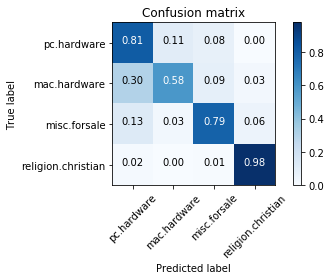

Accuracy for Multinomial NB from NMF:  0.792332268370607
Precision score for Multinomial NB from NMF:  0.8003665977557446
Recall score for Multinomial NB from NMF:  0.7906926496571148
F-1 score for Multinomial NB from NMF: 0.7884576782557926


In [9]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=['headers', 'footers'])),
    ('vect', CountVectorizer(min_df=5, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(random_state=42, n_components=50)),
    ('clf', MultinomialNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Multinomial NB from NMF: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Multinomial NB from NMF: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Multinomial NB from NMF: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Multinomial NB from NMF:', f1_score(y_test, predicted, average='macro'))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpcq17wndw'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpcq17wndw'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp364ztx9f'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp364ztx9f'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=['headers', 'footers']), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transf

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x5534 sparse matrix of type '<class 'numpy.int64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<2352x5534 sparse matrix of type '<class 'numpy.float64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
_________________________

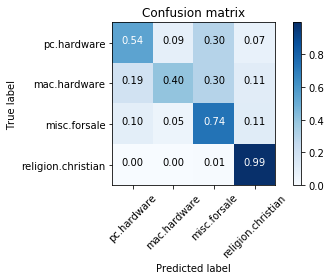

Accuracy for Gaussian NB from LSI:  0.6702875399361022
Precision score for Gaussian NB from LSI:  0.6796041532241356
Recall score for Gaussian NB from LSI:  0.6679221591999769
F-1 score for Gaussian NB from LSI: 0.6531172030402432


In [10]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=['headers', 'footers'])),
    ('vect', CountVectorizer(min_df=5, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42, n_components=50)),
    ('clf', GaussianNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Gaussian NB from LSI: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted, average='macro'))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpg3x9zdyp'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpg3x9zdyp'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpr79a2pzr'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpr79a2pzr'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=['headers', 'footers']), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transf

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x5534 sparse matrix of type '<class 'numpy.int64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0), 
<2352x5534 sparse matrix of type '<class 'numpy.float64'>'
	with 131795 stored elements in Compressed Sparse Row forma

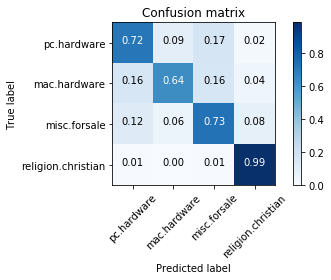

Accuracy for Gaussian NB from NMF:  0.7699680511182109
Precision score for Gaussian NB from NMF:  0.76929707673951
Recall score for Gaussian NB from NMF:  0.7684927225801239
F-1 score for Gaussian NB from NMF: 0.7653852416933962


In [12]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=['headers', 'footers'])),
    ('vect', CountVectorizer(min_df=5, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(random_state=42, n_components=50)),
    ('clf', GaussianNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Gaussian NB from NMF: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from NMF: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Gaussian NB from NMF: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Gaussian NB from NMF:', f1_score(y_test, predicted, average='macro'))

**SVM 1v1 method:**

In [21]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

## Pulled from Question 1
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )

twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)


X_train = twenty_train.data
y_train = twenty_train.target

X_test = twenty_test.data
y_test = twenty_test.target

[Memory]348.8s, 5.8min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\ee4e09301fdafe449357940f75c1cbf2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]348.9s, 5.8min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\a06b3cf1d324232fe99dbb6066a45630
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]349.1s, 5.8min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\01a1ae7f27b46a3b9fc414f20f69c9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]349.2s, 5.8min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\4cc43492d141962efbeb36153234500e
___________________________________fi

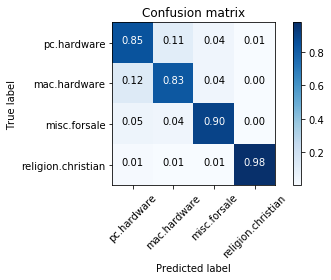

Accuracy for One vs One SVM from LSI:  0.8894568690095846
Precision score for One vs One SVM from LSI:  0.8896523442740364
Recall score for One vs One SVM from LSI:  0.8888653103297756
F-1 score for One vs One SVM from LSI: 0.8891812893554196


In [32]:
# Perform One vs One SVM classification

#reference: https://scikit-learn.org/stable/modules/svm.html (Multiclass Classification)

# ovo = one vs one classifier
clf_ovo = OneVsOneClassifier(LinearSVC(C=10, random_state=42))
# clf_ovo = svm.SVC(kernel='linear', decision_function_shape='ovo')

pipeline_ovo = Pipeline([
    ('import', Importer(remove=None)),
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42, n_components=50)),
    ('clf', clf_ovo),
],
memory=memory
)

pipeline_ovo.fit(X_train, y_train)

predicted_ovo = pipeline_ovo.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted_ovo), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display SVM Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for One vs One SVM from LSI: ', pipeline_ovo.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for One vs One SVM from LSI: ', precision_score(y_test, predicted_ovo, average='macro'))
print('Recall score for One vs One SVM from LSI: ', recall_score(y_test, predicted_ovo, average='macro'))
print('F-1 score for One vs One SVM from LSI:', f1_score(y_test, predicted_ovo, average='macro'))

**SVM one vs rest method:**

[Memory]520.8s, 8.7min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\ee4e09301fdafe449357940f75c1cbf2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]520.9s, 8.7min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\a06b3cf1d324232fe99dbb6066a45630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]521.1s, 8.7min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\01a1ae7f27b46a3b9fc414f20f69c9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]521.1s, 8.7min  : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpvg8l3v6j\joblib\sklearn\pipeline\_fit_transform_one\4cc43492d141962efbeb36153234500e
___________________________________fi

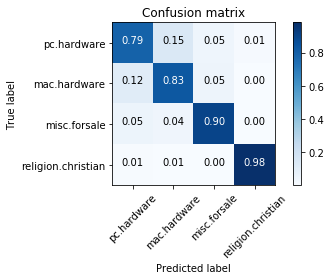

Accuracy for One vs Rest SVM from LSI:  0.8779552715654952
Precision score for One vs Rest SVM from LSI:  0.8773324842064207
Recall score for One vs Rest SVM from LSI:  0.8773780852433042
F-1 score for One vs Rest SVM from LSI: 0.8772738926493574


In [35]:
# ovr: one vs rest
clf_ovr = OneVsRestClassifier(LinearSVC(C=10, random_state=42))

pipeline_ovr = Pipeline([
    ('import', Importer(remove=None)),
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42, n_components=50)),
    ('clf', clf_ovr),
],
memory=memory
)

pipeline_ovr.fit(X_train, y_train)

predicted_ovr = pipeline_ovr.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted_ovr), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display SVM Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for One vs Rest SVM from LSI: ', pipeline_ovr.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for One vs Rest SVM from LSI: ', precision_score(y_test, predicted_ovr, average='macro'))
print('Recall score for One vs Rest SVM from LSI: ', recall_score(y_test, predicted_ovr, average='macro'))
print('F-1 score for One vs Rest SVM from LSI:', f1_score(y_test, predicted_ovr, average='macro'))